In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import torch
from scipy.interpolate import make_interp_spline, make_smoothing_spline, UnivariateSpline
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from matplotlib import gridspec, rcParams, rc
import spikeinterface.qualitymetrics as sqm
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from scipy.ndimage import gaussian_filter
import phate
import bisect
from kneed import KneeLocator
import math

In [2]:
# changing matplotlib font settings for prettier figures

rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})

SMALL_SIZE = 12
MEDIUM_SIZE = 14
LARGE_SIZE = 18
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
# load kilosort4 results

scratch = f'/home/lss72/palmer_scratch/spike_sort'
neuropixels = '/home/lss72/TempoSort/data/2017_UCL_Neuropixels'
neto = '/home/lss72/TempoSort/data/2016_rat_cortex_Neto_et_al'

def load_res(date, time):
    results_dir = Path(neto).joinpath(date).joinpath(f'{time}s')
    
    # outputs saved to results_dir
    # results_dir = Path(data_dir).joinpath('kilosort4')
    
    # load 'em
    ops = np.load(results_dir / 'ops.npy', allow_pickle=True).item()
    camps = pd.read_csv(results_dir / 'cluster_Amplitude.tsv', sep='\t')['Amplitude'].values
    contam_pct = pd.read_csv(results_dir / 'cluster_ContamPct.tsv', sep='\t')['ContamPct'].values
    chan_map =  np.load(results_dir / 'channel_map.npy')
    templates =  np.load(results_dir / 'templates.npy')
    chan_best = (templates**2).sum(axis=1).argmax(axis=-1)
    chan_best = chan_map[chan_best]
    amplitudes = np.load(results_dir / 'amplitudes.npy')
    st = np.load(results_dir / 'spike_times.npy')
    clu = np.load(results_dir / 'spike_clusters.npy')
    firing_rates = np.unique(clu, return_counts=True)[1] * 30000 / st.max()
    dshift = ops['dshift']
    
    return ops, camps, contam_pct, chan_map, templates, chan_best, amplitudes, st, clu, firing_rates, dshift

ops, camps, contam_pct, chan_map, templates, chan_best, amplitudes, st, clu, firing_rates, dshift = load_res('2014_11_25_Pair_3_0', 300)

In [4]:
# import data

inputfilename = f'{scratch}/2014_11_25_Pair_3_0/adc2014-11-25T23_00_08.bin'
filename = f"{scratch}/2014_11_25_Pair_3_0/amplifier2014-11-25T23_00_08.bin"
# inputfilename = f'{scratch}/2014_11_13_Pair_3_0/adc2014-11-13T18_48_11.bin'
# filename = f"{scratch}/2014_11_13_Pair_3_0/amplifier2014-11-13T18_48_11.bin"

Sampling_frequency = 30_000  #Hz
Probe_numChannels = 32
Probe_dtype = np.uint16
Probe_voltage_step_size = 0.195e-6
Probe_y_digitization = 32768
Juxta_numChannels = 8
Juxta_dtype = np.uint16
Juxta_ADC_used_channel = 0
Juxta_Gain = 100
Juxta_y_digitization = 65536
Juxta_y_range=10
distance_min = 31
Probe_closest_electrode = 23

# helper functions
### The code below has been adapted from:
# https://github.com/georgedimitriadis/themeaningofbrain/
# (see usage in https://github.com/georgedimitriadis/themeaningofbrain/blob/master/ExperimentSpecificCode/_2015_Paired_Recordings_JN/Joana_Neto/

def split_list_pairwise(l,p):
    groups = []
    prev = None
    group = None
    for x in l:
        if prev is None or p(x,prev):
            group = []
            groups.append(group)
        group.append(x)
        prev = x
    return groups


def custom_find_peaks(data_raw_spikes, threshold, inter_spike_time_distance=30, amp_gain=100,
                                  sampling_freq=30000, amp_y_digitization=65536, amp_y_range=10):

    scaling_factor = amp_y_range / (amp_y_digitization * amp_gain)
    data_in_v = (data_raw_spikes - np.mean(data_raw_spikes)) * scaling_factor

    derivative = np.diff(np.sign(np.diff(data_in_v))) #check when deriv changes sign
    if threshold > 0:
        derivative = derivative < 0
    else:
        derivative = derivative > 0

    peaks = np.flatnonzero(derivative) + 1  # local max
    if threshold > 0:
        peaks = peaks[data_in_v[peaks] > threshold]
    else:
        peaks = peaks[data_in_v[peaks] < threshold]

    if inter_spike_time_distance > 0:
        gpeaks = split_list_pairwise(peaks, lambda x, p: x - p > inter_spike_time_distance)
        peaks = np.array([g[np.argmax([data_in_v[i] for i in g])] for g in gpeaks])
    return peaks, data_in_v


# Load data from bin files into a matrix of n channels x m samples 
def loadRawData(filename, numChannels, dtype):
    
    fdata = np.fromfile(filename,dtype=dtype)
    assert len(fdata) % numChannels == 0
    numsamples = len(fdata) // numChannels
    data = np.reshape(fdata,(numsamples, numChannels))
    
    return np.transpose(data)

juxta_threshold = 0.8e-3 #using the one in paired_32ch.py! NOT the one in DataSummary.xlsx
inter_spike_time_distance = 30 # (30 samples = 1 ms)

juxta = loadRawData(inputfilename, numChannels = Juxta_numChannels, dtype = Juxta_dtype)
# the rescaling below (from 2014_11_13_Pair_1_0_Software.docx) looks wrong! 
# juxta_channel_Volts = juxta [Juxta_ADC_used_channel, :] * (Juxta_y_range /( Juxta_y_digitization * Juxta_Gain))
# based on the code for the IO.ephys.find_peaks function, must substract the mean first in order to use the threshold
# value provided in DataSummary.xlsx


# Generate the spike time triggers (and the adc traces in Volts) for the cell recorded juxta cellularly

spike_triggers, spike_data_in_V = custom_find_peaks(juxta[Juxta_ADC_used_channel],
                                                    threshold=juxta_threshold,
                                                    inter_spike_time_distance=inter_spike_time_distance,
                                                    amp_gain=Juxta_Gain,
                                                    amp_y_range=Juxta_y_range)


# loading extra data

extra = loadRawData(filename, numChannels = Probe_numChannels, dtype = Probe_dtype) 

extra_Volts = (extra - Probe_y_digitization) * Probe_voltage_step_size

In [5]:
# High pass filter

# diffusion distances; manha distancees

from scipy.signal import butter, filtfilt

filtered_data_type = np.float32
num_of_points_in_spike_trig_ivm = 30
num_of_points_for_padding = num_of_points_in_spike_trig_ivm//2
num_of_spikes = len(spike_triggers)

#Filter for extracellular recording
def highpass(data,BUTTER_ORDER=3, F_HIGH=14250,sampleFreq=Sampling_frequency,passFreq=100.0):
    b, a = butter(BUTTER_ORDER,(passFreq/(sampleFreq/2.), F_HIGH/(sampleFreq/2.)),'pass')
    return filtfilt(b,a,data)

shape_spike_data = (num_of_spikes, Probe_numChannels, num_of_points_in_spike_trig_ivm)
ivm_data_filtered = np.zeros(shape_spike_data, dtype=filtered_data_type)
ivm_data_unfiltered = np.zeros(shape_spike_data, dtype=extra_Volts.dtype)

for spike_i in range(num_of_spikes):
    if (spike_i + 1) % 25 == 0:
        print(spike_i +1, end=' ', flush=True)

    trigger_point = spike_triggers[spike_i]
    start_point = int(trigger_point - (num_of_points_in_spike_trig_ivm + num_of_points_for_padding))
    assert start_point >= 0
    end_point = int(trigger_point + (num_of_points_in_spike_trig_ivm + num_of_points_for_padding))
    if end_point > extra.shape[1]:
        break
        
    temp_unfiltered = extra_Volts[:, start_point:end_point].astype(filtered_data_type)
    ivm_data_unfiltered[spike_i] = temp_unfiltered[:, num_of_points_in_spike_trig_ivm:-num_of_points_in_spike_trig_ivm]
    temp_filtered = highpass(temp_unfiltered)
    temp_filtered = temp_filtered[:, num_of_points_in_spike_trig_ivm:-num_of_points_in_spike_trig_ivm]
    ivm_data_filtered[spike_i] = temp_filtered

25 50 75 100 125 150 175 200 225 250 275 300 325 

In [17]:
from scipy.signal import butter, filtfilt

# Fcutoff = 200
# Fsampling = 30000

# Wn = np.float32(Fcutoff / (Fsampling / 2.0))
# filterOrder = 6
# #
# b, a = butter(filterOrder, Wn, btype='highpass', analog=0, output='ba')

# data_array = np.zeros(extra_Volts.shape)
# data_array_old = extra_Volts

# for chan in tqdm(range(len(data_array))):
#     data_array[chan,:] = filtfilt(b, a, data_array_old[chan,:])

def get_highpass_filter(fs=30000, cutoff=300, device=torch.device('cuda')):
    """Filter to use for high-pass filtering."""
    NT = 30122
    
    # a butterworth filter is specified in scipy
    b,a = butter(3, cutoff, fs=fs, btype='high')

    # a signal with a single entry is used to compute the impulse response
    x = np.zeros(NT)
    x[NT//2] = 1

    # symmetric filter from scipy
    hp_filter = filtfilt(b, a , x).copy()
    
    hp_filter = torch.from_numpy(hp_filter).to(device).float()
    return hp_filter

def fft_highpass(hp_filter, NT=30122, device=torch.device('cuda')):
    """Convert filter to fourier domain."""
#     device = hp_filter.device
    ft = hp_filter.shape[0]

    # the filter is padded or cropped depending on the size of NT
    if ft < NT:
        pad = (NT - ft) // 2
        fhp = fft(torch.cat((torch.zeros(pad).to(device), 
                             hp_filter,
                             torch.zeros(pad + (NT-pad*2-ft)).to(device))))
    elif ft > NT:
        crop = (ft - NT) // 2 
        fhp = fft(hp_filter[crop : crop + NT])
    else:
        fhp = fft(hp_filter)
    return fhp

from torch.fft import fft, ifft, fftshift
sample_rate = 30000


# filter raw data -- do it one channel at a time due to memory constraints
data_array = extra_Volts
hp_filter = get_highpass_filter(sample_rate)
for i in tqdm(range(len(chan_map))):
    chan = chan_map[i]
    
    X = torch.from_numpy(data_array[chan:chan+1]).to(torch.device('cuda'))

    # apply filter in Fourier space
    fwav = fft_highpass(hp_filter, NT=X.shape[1])
    X = torch.real(ifft(fft(X) * torch.conj(fwav)))
    X = fftshift(X, dim = -1)
    
    data_array[chan] = X[0].cpu() #grab the single row from X corresponding to chan

100%|██████████| 32/32 [00:13<00:00,  2.42it/s]


In [26]:
# getting spike windows
def get_spike_windows(d_array=spike_data_in_V):

    window_half_size = 30 #1 ms = 30
    
    sp_windows = []
    for peak_i in range(len(spike_triggers)):
        
        ix = spike_triggers[peak_i]
        window_ixs = np.arange(ix - window_half_size, ix + window_half_size + 1)
        sp_windows.append(d_array[window_ixs])

    return np.array(sp_windows)

def get_spike_windows_extra():
    window_half_size = 30 #1 ms = 30
    
    sp_windows = []
    for peak_i in range(len(spike_triggers)):
        extra_chan = Probe_closest_electrode
        sp_windows.append(ivm_data_filtered[peak_i,extra_chan])

    return np.array(sp_windows)


def get_spike_windows_per_template(templi, d_array=data_array):
    which_spikes_from_templ = np.flatnonzero(clu == templi)
    half_window = templates.shape[1]//2
    which_chans = [Probe_closest_electrode]
    
    # crop out a window around the spike times for each channel in this template
    # use `st[spki]` to get the actual time (sample #) of each spike
    all_spk_windows = []
    actual_spike_ts = st[which_spikes_from_templ]
    for spki in which_spikes_from_templ:
        t0, t1 = max(0, st[spki]-half_window), min(st[spki]+half_window+1, d_array.shape[1])
        
        if t1 - t0 < 2*half_window+1:
            start, end = 0, 2*half_window+1
            window = 0*np.ones((len(which_chans),2*half_window+1))
            if st[spki] < half_window:
                start = half_window-st[spki]
            if st[spki] + half_window + 1 > d_array.shape[1]:
                end -= ( d_array.shape[1] - st[spki] + half_window + 1 )
        
            window[:,start:end] = d_array[which_chans,t0:t1]
        else:
            window = d_array[which_chans,t0:t1]

        if window.max() - window.min() < 0.008:
            all_spk_windows.append(window)

    return all_spk_windows



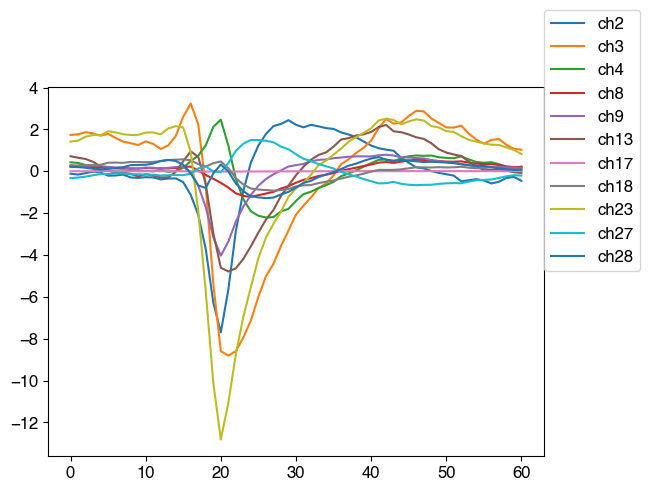

In [11]:
n_chan = 32

templi = temp_to_use #choose a given template

# these show the waveforms for several channels in a given template (channels not considered are zeroed)
# templates.shape (#template, #time pts, #num good channels)

which_chans = []
for i in range(n_chan): #plot the waveform from each channel participating in that template
    if abs(templates[templi,:,i]).sum() > 0:
        which_chans.append(chan_map[i]) #convert the channel index (0--373) to the global index (0--384, the full probe)
        plt.plot(templates[templi,:,i], label=f'ch{i}');
plt.legend(loc=(1,.5))
plt.show()

assert np.all(which_chans == np.flatnonzero(abs(templates[templi]).sum(0) > 0))

In [59]:
spike_triggers

array([ 136321,  205646,  247435,  279578,  339509,  447771,  536308,
        538124,  586805,  674608,  725926,  759080,  883489, 1049589,
       1256150, 1425909, 1426131, 1427460, 1427652, 1707930, 1755543,
       1933590, 1934274, 2130475, 2140520, 2179836, 2232895, 2394353,
       2475085, 2490556, 2493372, 2493785, 2671192, 2671924, 2847797,
       3179040, 3179363, 3257489, 3350948, 3541017, 3544196, 3544369,
       3545535, 3549162, 3551447, 3631610, 3631894, 3633782, 3649604,
       3650510, 3650917, 3908881, 3911352, 3968821, 4048758, 4061897,
       4098693, 4100436, 4101559, 4102164, 4103321, 4145263, 4148737,
       4155837, 4234326, 4242402, 4250416, 4279749, 4285220, 4302368,
       4340501, 4354765, 4358374, 4359593, 4360809, 4502712, 4510892,
       4562442, 4562684, 4612712, 4732538, 5078239, 5092709, 5093538,
       5258857, 5537046, 5538322, 5592947, 5593845, 5769234, 6006976,
       6009359, 6057985, 6058821, 6060807, 6130651, 6147501, 6163034,
       6176517, 6176

In [60]:
st[which_spikes_from_templ]

array([   5473,    5937,    9241,   11039,   11106,   12322,   12576,
         12654,   14015,   14219,   15499,   21778,   24050,   24302,
         24493,   24502,   24548,   24556,   25091,   25264,   25342,
         25420,   31693,   34896,   35031,   35551,   36002,   40213,
         48092,   56127,   56478,   56639,   56858,   56944,   60675,
         61076,   64104,   64603,   66169,   67057,   68972,   69355,
         72726,   80719,   86341,   86900,   91848,   97501,   98702,
        125971,  130512,  134621,  134828,  135050,  146939,  153425,
        153841,  157452,  157598,  160243,  165229,  168519,  173935,
        174263,  181768,  193862,  196146,  196447,  202203,  207321,
        211038,  211815,  211937,  212215,  221849,  222025,  222503,
        223881,  224009,  236144,  236994,  237254,  248282,  266109,
        266872,  272605,  275113,  275839,  277896,  278110,  279163,
        279328,  279883,  292936,  298624,  301727,  311849,  312180,
        312300,  312

In [10]:
temp_to_use = np.argsort(abs(templates[:,:,Probe_closest_electrode]).sum(axis=1))[-1]
print(temp_to_use)
which_spikes_from_templ = np.flatnonzero(clu == temp_to_use)

6


In [112]:
which_spikes_from_templ0 = np.flatnonzero(clu == 0)
assert st[which_spikes_from_templ0] == st[which_spikes_from_templ]

ValueError: operands could not be broadcast together with shapes (2285,) (281,) 

In [63]:
data_array.shape

(32, 9307200)

In [64]:
spike_data_in_V.shape

(9307200,)

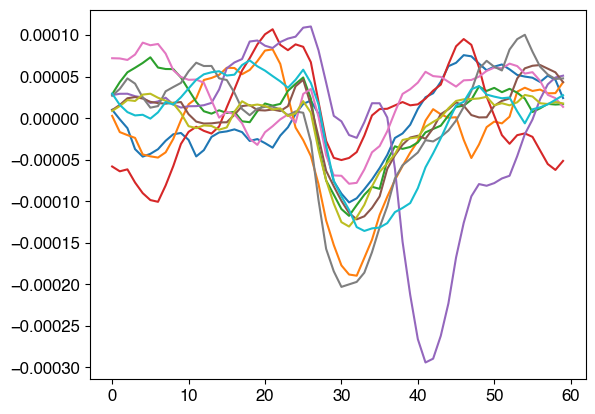

In [12]:

# print(len(which_spikes_from_templ))
    
for t in spike_triggers[:10]:
    # print(t)
    plt.plot(data_array[Probe_closest_electrode,t-30:t+30])

(array([152.,  23.,   5.,   4.,   3.,   2.,   5.,   4.,   2.,   2.,   9.,
          4.,   7.,   7.,  23.,  16.,  12.,   7.,  20.,   7.,   9.,   5.,
          4.,   5.,   1.,   2.,   2.,   0.,   3.,   3.]),
 array([1.000000e+01, 2.437820e+05, 4.875540e+05, 7.313260e+05,
        9.750980e+05, 1.218870e+06, 1.462642e+06, 1.706414e+06,
        1.950186e+06, 2.193958e+06, 2.437730e+06, 2.681502e+06,
        2.925274e+06, 3.169046e+06, 3.412818e+06, 3.656590e+06,
        3.900362e+06, 4.144134e+06, 4.387906e+06, 4.631678e+06,
        4.875450e+06, 5.119222e+06, 5.362994e+06, 5.606766e+06,
        5.850538e+06, 6.094310e+06, 6.338082e+06, 6.581854e+06,
        6.825626e+06, 7.069398e+06, 7.313170e+06]),
 <BarContainer object of 30 artists>)

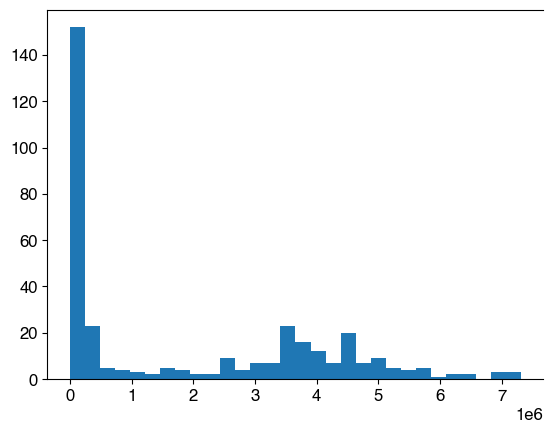

In [29]:
sp_diff = [abs(sp - st[which_spikes_from_templ]).min() for sp in spike_triggers]

plt.hist(sp_diff, bins=30)

In [7]:
# load original templates
dd = np.load('wTEMP.npz')
wTEMP = dd['wTEMP']
# visualize each waveform
for w in wTEMP:
    plt.plot(w)
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'wTEMP.npz'

In [14]:
def gaussian_weights(x, mu=None, sigma=1.0, normalize=True):
    """
    Compute Gaussian weights for a given vector.

    Parameters:
    - x (array-like): Input vector.
    - mu (float): Mean of the Gaussian. Defaults to center of x.
    - sigma (float): Standard deviation.
    - normalize (bool): Whether to normalize weights to sum to 1.

    Returns:
    - np.ndarray: Gaussian weights corresponding to elements in x.
    """
    x = np.linspace(0, len(x), num=len(x))
    if mu is None:
        mu = np.median(range(0, len(x)))

    weights = np.exp(-((x - mu) ** 2) / (2 * sigma ** 2)) + 1
    
    if normalize:
        weights /= np.sum(weights)
    
    return weights

(428, 61)


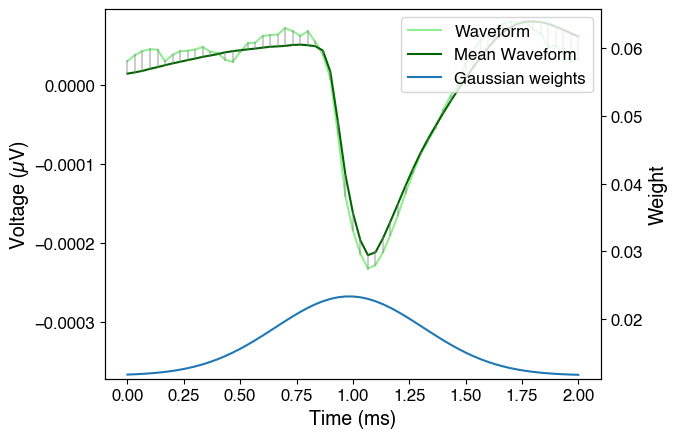

In [36]:
# creating Gaussian blur

t_num = temp_to_use

# setting right spine to true for this plot
rcParams['axes.spines.right'] = True

# colors
color_n = 'orange'
color_4d = 'forestgreen'
color_pca = 'darkviolet'
color_phate = 'steelblue'

# constants
SAMP_RATE = 30 # samples per ms
half_ms_len = int(round(.5 * SAMP_RATE))
slope_delta = int(round(SAMP_RATE/10.))

# getting waves for each template (default 0)
# waves = get_spike_windows_extra()
waves = np.squeeze(get_spike_windows_per_template(t_num))
print(waves.shape)

gauss_1 = gaussian_filter(waves, sigma=1, axes=0)
gauss_5 = gaussian_filter(waves, sigma=5, axes=0)

# generating gaussian weights given vector
med_weights = gaussian_weights(waves[0], sigma=10.0)

# mean
mean_naive = waves.mean(axis=0)

fig, ax = plt.subplots()
ax2 = ax.twinx()

# ax.plot(gauss_1[0], label='gauss 1')
# ax.plot(gauss_5[0], label='gauss 5')
xlabels = [x/SAMP_RATE for x in range(len(waves[0]))]
l1 = ax.plot(xlabels, waves[0], label='Waveform', color='lightgreen')
l2 = ax.plot(xlabels, mean_naive, label='Mean Waveform', color='darkgreen')
l3 = ax2.plot(xlabels, med_weights, label='Gaussian weights')

# adding residuals
for i in range(len(waves[0])):
    ax.plot([i/SAMP_RATE, i/SAMP_RATE], [min(waves[0][i], mean_naive[i]), max(waves[0][i], mean_naive[i])], color='grey', alpha = 0.4)
    

# concat lines to create a single legend
lines = l1 + l2 + l3
labs = [l.get_label() for l in lines]
ax.legend(lines, labs, loc='upper right')

# adding axes labels
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Voltage (µV)')
ax2.set_ylabel('Weight')

# changing plot height
ax2.set_ylim(ax2.get_ylim()[0], ax2.get_ylim()[1]*2.75)
ax.set_ylim(ax.get_ylim()[0]*1.5, ax.get_ylim()[1]*1)

# plt.savefig('residual_plot')

plt.show()

# undoing right spine show
rcParams['axes.spines.right'] = False


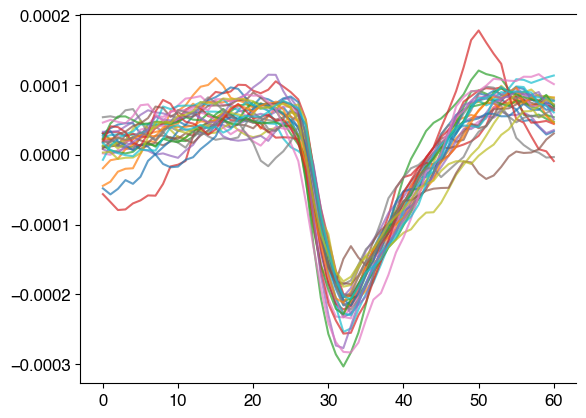

In [28]:
for i in waves[:30]:
    plt.plot(range(61), i, alpha=0.7)

In [13]:
# dim of waveform
print(waves[0].shape)

(61,)


In [31]:
# analysis of waveforms for each method

# todo: filter with gaussian blur and also try with unfiltered data
# also plot the 4d characteristics w/ legend etc

# for naive: can weight each time point either using gaussian or look at a small window bc this is lower power 
# make plot with variance of 0-120 etc
# set y limits to be min y on LB and max y on UB.

def generate_sorted_waves(waves, calc_var = False, phate_bool=False):

    # getting mean for each metric
    pca = PCA(n_components=4)
    pcs = pca.fit_transform(waves)
    if phate_bool:
        phate_op = phate.PHATE(4,  knn=100, n_jobs=-1)
        phate_coords = phate_op.fit_transform(waves)
        mean_phate = phate_coords.mean(axis=0)
    mean_naive = waves.mean(axis=0)
    mean_pca = pcs.mean(axis=0)
    all_4d = []
    
    for wave in waves:
    
        dp_val, dp_t = np.min(wave[2:-slope_delta - half_ms_len]), np.argmin(wave[2:-slope_delta - half_ms_len]) + 2
        ahp_val, ahp_t = np.max(wave[dp_t+1:]),np.argmax(wave[dp_t+1:]) #peak after trough
        bhp_val = np.max(wave[:dp_t])
            
        params = np.empty(4) # 4 columns for: after-hyper:depolar ratio, 
                                # trough to after-hyper time, slope 0.5 ms after trough
    
        params[0] = ahp_val/dp_val;
        params[1] = ahp_t/SAMP_RATE;
        params[3] = bhp_val/-dp_val
    
        slope_t = dp_t+half_ms_len
        interval = slope_t - slope_delta, slope_t + slope_delta
    
        # #slope at (dp_t + half_ms_len) == dp_t + 0.5 ms
        params[2] = (wave[interval[1]] - wave[interval[0]])/((interval[1] - interval[0])/SAMP_RATE)
    
        all_4d.append(params)
    
    mean_4d = np.mean(all_4d, axis=0)
    
    # getting distance for all waves from the 3 means
    naive_dists, four_d_dists, pca_dists, phate_dists = [], [], [], []
    for i, wave in enumerate(waves):
        
        naive_dists.append((np.linalg.norm(wave - mean_naive), i))
        four_d_dists.append((np.linalg.norm(all_4d[i] - mean_4d), i))
        pca_dists.append((np.linalg.norm(np.squeeze(pca.transform([wave])) - mean_pca), i))
        if phate_bool:
            phate_dists.append((np.linalg.norm(phate_coords[i] - mean_phate), i))
    
    # sorting by dist to mean
    naive_dists = sorted(naive_dists, key=lambda x: x[0])
    four_d_dists = sorted(four_d_dists, key=lambda x: x[0])
    pca_dists = sorted(pca_dists, key=lambda x: x[0])
    if phate_bool:
        phate_dists = sorted(phate_dists, key=lambda x: x[0])
    

    if not calc_var:   
        # creating 16 evenly spaced indices   
        indices = np.linspace(0, len(waves) - 1, 17).round().astype(int) 
        return naive_dists, four_d_dists, pca_dists, phate_dists, indices

    else:

        # creating 17 evenly spaced indices --> 16 plots   
        indices = np.linspace(0, len(waves) - 1, 17).round().astype(int) 
        std_naive, std_4d, std_pca, std_phate = [], [], [], []

        s = indices[0]
        for f in indices[1:]:
            _, i_naive = zip(*naive_dists[s:f])
            _, i_4d = zip(*four_d_dists[s:f])
            _, i_pca = zip(*pca_dists[s:f])
            std_naive.append(np.var(waves[list(i_naive)], axis=0))
            std_4d.append(np.var(waves[list(i_4d)], axis=0))
            std_pca.append(np.var(waves[list(i_pca)], axis=0))
            if phate_bool:
                _, i_phate = zip(*phate_dists[s:f])
                std_phate.append(np.var(waves[list(i_phate)], axis=0))
            s = f

        return std_naive, std_4d, std_pca, std_phate, indices

naive_dists, four_d_dists, pca_dists, phate_d, indices = generate_sorted_waves(waves, phate_bool=False)
naive_g1, four_d_g1, pca_g1, phate_g1, ind_g1 = generate_sorted_waves(gauss_1)
naive_g5, four_d_g5, pca_g5, phate_g2, ind_g5 = generate_sorted_waves(gauss_5)
var_naive, std_4d, std_pca, std_phate, ind_std = generate_sorted_waves(waves, True, phate_bool=False)

# getting gaussian-weighted std of each bin
std_naive = [np.sqrt(x) for x in var_naive]
var_naive_avg    = np.average(var_naive,    axis=1, weights=med_weights)
std_naive_avg    = np.average(std_naive,    axis=1, weights=med_weights)
std_4d_avg       = np.average(std_4d,       axis=1, weights=med_weights)
std_pca_avg      = np.average(std_pca,      axis=1, weights=med_weights)

var_naive_g1, _, _, _, _ = generate_sorted_waves(gauss_1, True)
std_naive_g1 = [np.sqrt(x) for x in var_naive_g1]
std_naive_g1_avg  = np.average(std_naive_g1,  axis=1, weights=med_weights)
var_naive_g1_avg  = np.average(var_naive_g1,  axis=1, weights=med_weights)

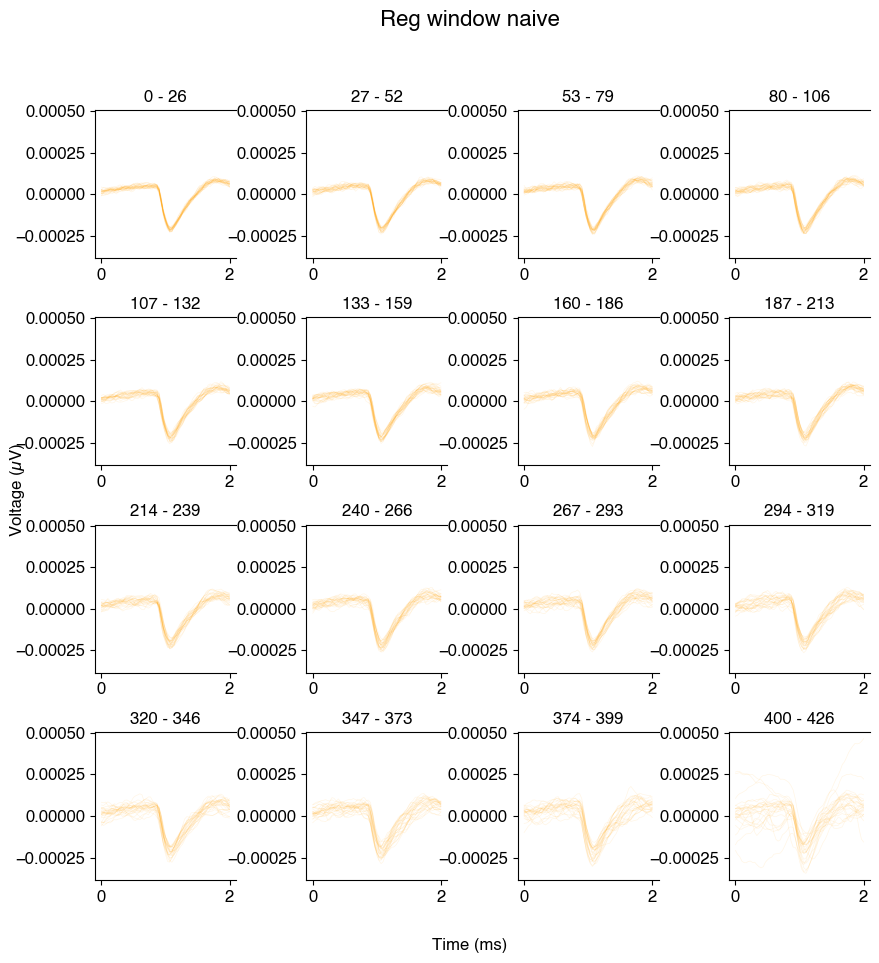

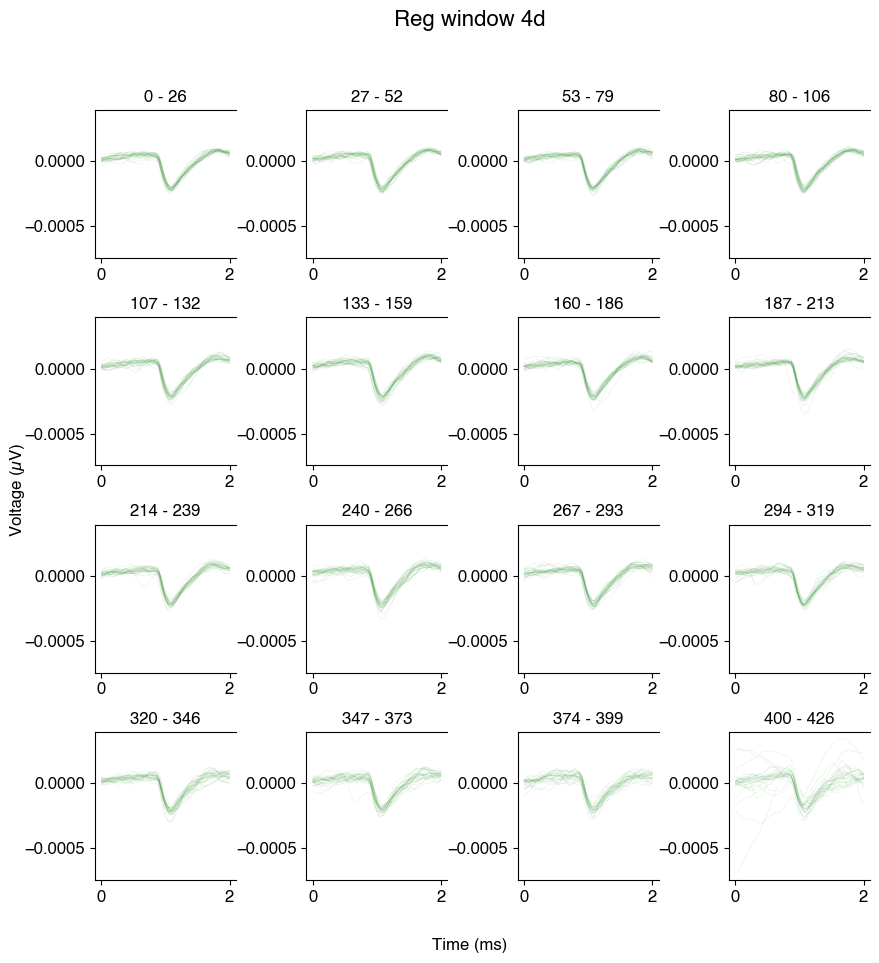

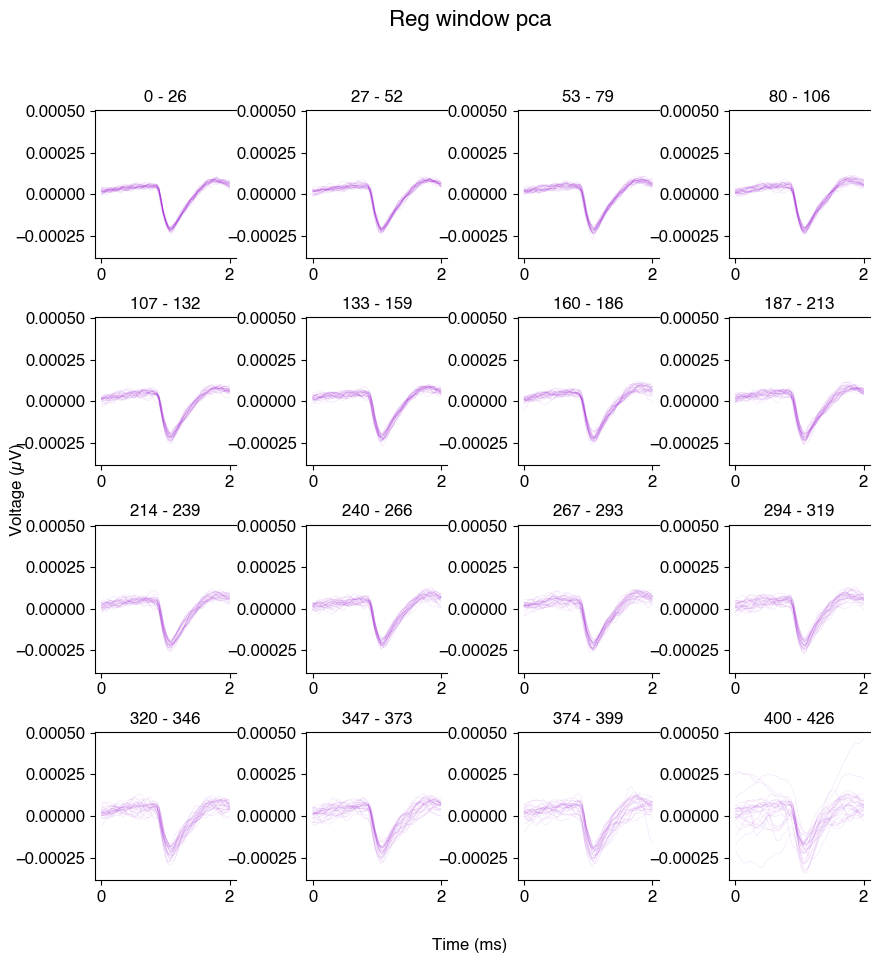

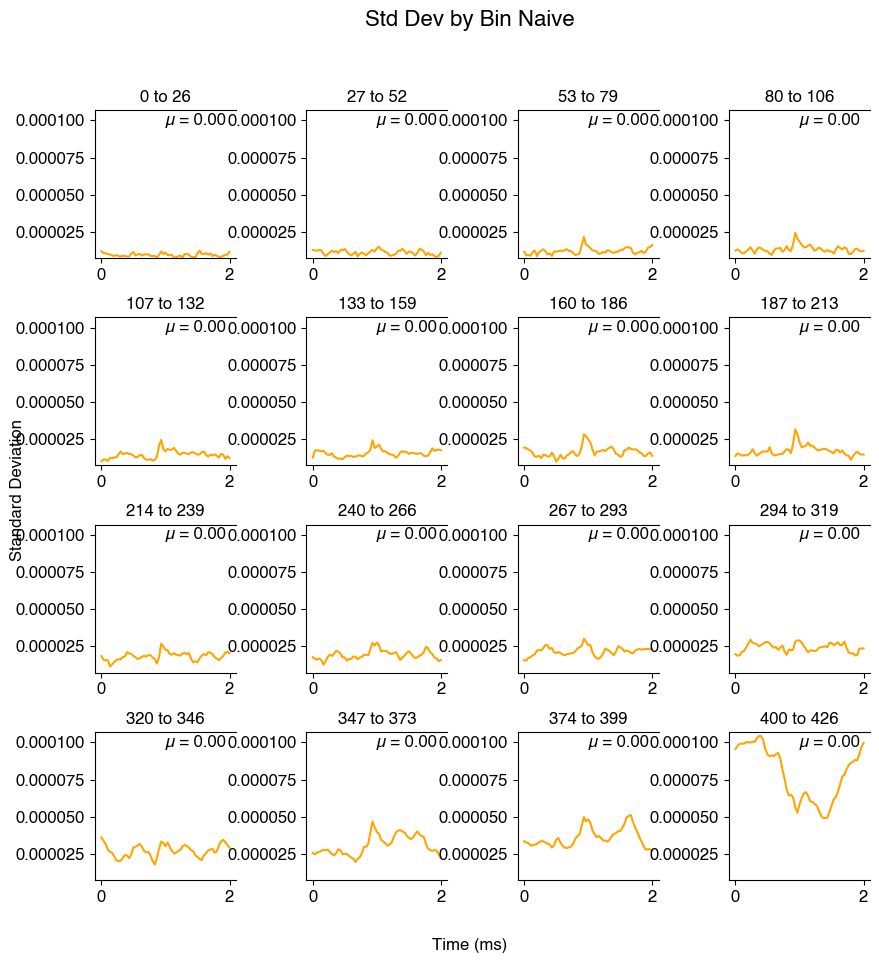

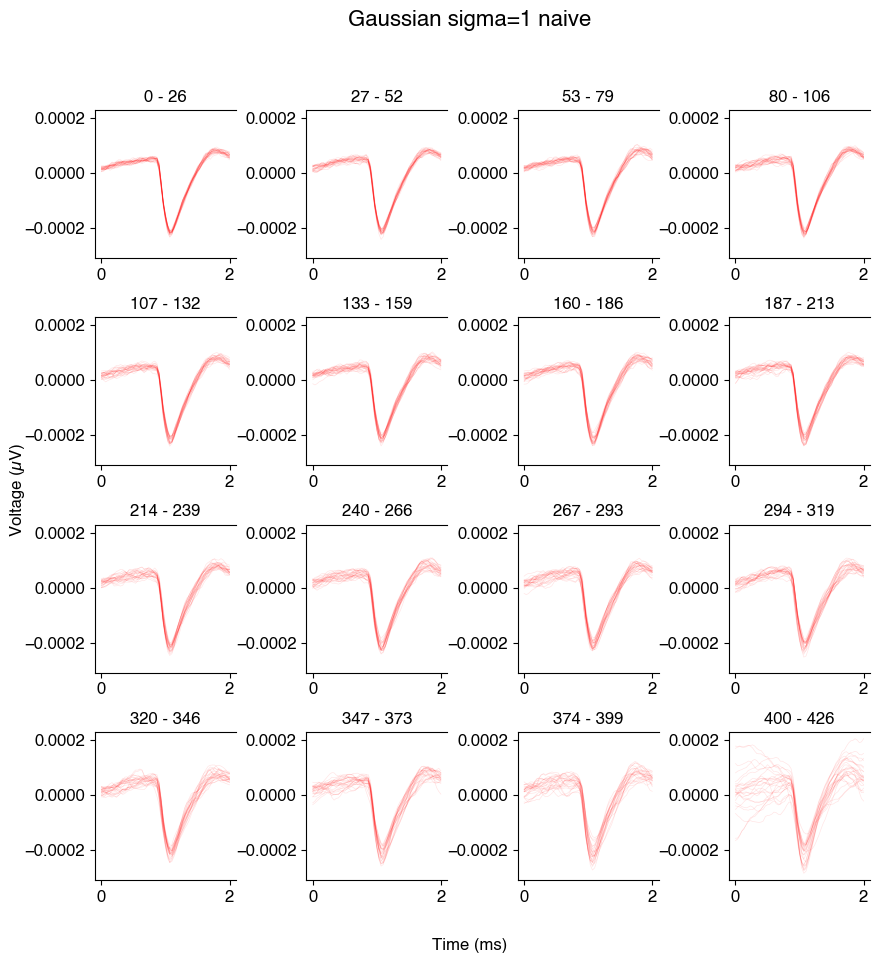

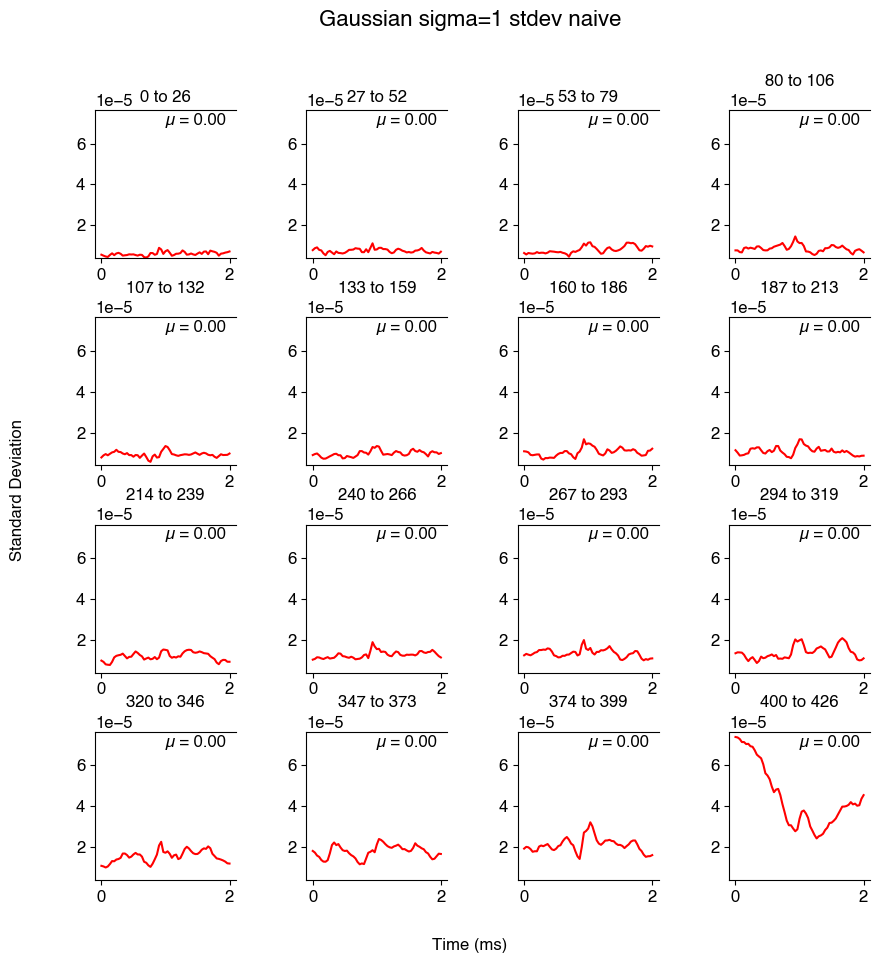

In [32]:
# take extracellular data and run through kilosort. figure out the probe. repeat everything i'm doing with the new data. 

def plot_waveforms(waves, dists, indices, color, title):
    NUM_SAMP_PER_SEC = 30000
    xlabels = [(x*1000)/NUM_SAMP_PER_SEC for x in range(0, len(waves[0]))]
    ylow, yhigh, axes = [], [], []
    fig = plt.figure(figsize=(10,10), dpi=100)
    grid = gridspec.GridSpec(4, 4, figure=fig, hspace=0.4, wspace=0.5)

    s = indices[0]
    for i, f in enumerate(indices[1:]):
        axes.append(fig.add_subplot(grid[i // 4, i % 4]))

        _, i_bin = zip(*dists[s:f])
        nb=axes[-1].plot(xlabels, waves[list(i_bin)].T, color=color, alpha=0.1, lw=0.5)
        axes[-1].set_title(f'{s} - {f-1}')
        _, _, yl, yh = axes[-1].axis()
        ylow.append(yl)
        yhigh.append(yh)
        s = f
    
    for ax in axes:
        ax.set_ylim([min(ylow), max(yhigh)])

    fig.text(0.5, 0.04, 'Time (ms)', ha='center')
    fig.text(0.04, 0.5, 'Voltage (µV)', va='center', rotation='vertical')
    
    plt.suptitle(title)
    plt.savefig(title)

    plt.show()

def plot_std_of_bin(std, avg, indices, color, title):
    NUM_SAMP_PER_SEC = 30000
    xlabels = [(x*1000)/NUM_SAMP_PER_SEC for x in range(0, len(std[0]))]
    ylow, yhigh, axes = [], [], []
    
    fig = plt.figure(figsize=(10,10), dpi=100)
    grid = gridspec.GridSpec(4, 4, figure=fig, hspace=0.4, wspace=0.5)

    s = indices[0]
    for i, f in enumerate(indices[1:]):
        axes.append(fig.add_subplot(grid[i // 4, i % 4]))
        nb=axes[-1].plot(xlabels, std[i], color=color)
        axes[-1].set_title(f'{s} to {f-1}')
        axes[-1].annotate(f'µ = {avg[i]:.2f}', xy=(0.50, 0.90), xycoords='axes fraction')
        _, _, yl, yh = axes[-1].axis()
        ylow.append(yl)
        yhigh.append(yh)
        s = f
    
    for ax in axes:
        ax.set_ylim([min(ylow), max(yhigh)])

    fig.text(0.5, 0.04, 'Time (ms)', ha='center')
    fig.text(0.04, 0.5, 'Standard Deviation', va='center', rotation='vertical')
    
    plt.suptitle(title)
    # plt.savefig(title)

    plt.show()
    
plot_waveforms(waves, naive_dists, indices, color_n, 'Reg window naive')
plot_waveforms(waves, four_d_dists, indices, color_4d, 'Reg window 4d')
plot_waveforms(waves, pca_dists, indices, color_pca, 'Reg window pca')
# plot_waveforms(waves, phate_d, indices, color_phate, 'Reg window phate')

plot_std_of_bin(std_naive, std_naive_avg, ind_std, color_n, 'Std Dev by Bin Naive')
plot_waveforms(gauss_1, naive_g1, ind_g1, 'red', 'Gaussian sigma=1 naive')
plot_std_of_bin(std_naive_g1, std_naive_g1_avg, ind_std, 'red', 'Gaussian sigma=1 stdev naive')

In [46]:
# calculating contamination using wave morphology

# thresh = []

# for t_num in tqdm(range(len(templates))):
#     waves = np.squeeze(get_spike_windows(t_num))
#     mean_naive = waves.mean(axis=0)

#     # calculating dists
#     naive_dists = []
#     for i, wave in enumerate(waves):
            
#         naive_dists.append((np.linalg.norm(wave - mean_naive), i))

#     # sort by dist to mean
#     naive_dists = sorted(naive_dists, key=lambda x: x[0])
    
#     # creating 17 evenly spaced indices --> 16 plots   
#     indices = np.linspace(0, len(waves) - 1, 17).round().astype(int) 
#     std_naive = []

#     # getting binned stdev
#     s = indices[14]
#     f = indices[15]
#     _, i_naive = zip(*naive_dists[s:f])
#     to_add = np.sqrt(np.var(waves[list(i_naive)], axis=0))
#     thresh.append(np.average(to_add, weights=med_weights))
# np.mean(thresh) # 

def contamination_morph():

    # changing the gaussian weighting so that the center index has full weight
    middle = np.take(med_weights, med_weights.size // 2)
    center_norm_weights = med_weights * (1/middle)


    c_list = []

    for t_num in tqdm(range(len(templates))):
    
        # get all spike templates
        waves = np.squeeze(get_spike_windows_per_template(t_num))
        waves = gaussian_filter(waves, sigma=1, axes=0)
    
        # getting mean for each metric
        # pca = PCA(n_components=4)
        # pcs = pca.fit_transform(waves)
        mean_naive = waves.mean(axis=0)
        # mean_pca = pcs.mean(axis=0)
    
        # getting distance for all waves from the 3 means
        naive_dists = []
        for i, wave in enumerate(waves):
            weighted = np.multiply(wave - mean_naive, center_norm_weights)
            naive_dists.append((np.linalg.norm(weighted), i))
            # pca_dists.append(np.linalg.norm(np.squeeze(pca.transform([wave])) - mean_pca))
        
        naive_dists = sorted(naive_dists, key=lambda x: x[0])
        dists, _ = zip(*naive_dists)

        # threshhold calculation

        # creating 17 evenly spaced indices --> 16 plots   
        num_ind = 17

        if num_ind > len(waves):
            indices = list(range(len(waves)))
            num_ind = len(waves)
        else:
            indices = np.linspace(0, len(waves) - 1, num_ind).round().astype(int) 
        len_std = num_ind - 1
        
        std_naive = []

        s = indices[0]
        for f in indices[1:]:
            _, i_naive = zip(*naive_dists[s:f])
            std_naive.append(np.var(waves[list(i_naive)], axis=0))
            s = f

        std_naive = np.average(std_naive, axis=1, weights=med_weights)

        middle = len_std // 2

        kneedle = KneeLocator(range(len_std - middle), std_naive[middle:], S=1, curve="convex")
        
        try:
            thresh_x = math.ceil(kneedle.knee)
        except: 
            thresh_x = len_std - middle - 1
            
        thresh = std_naive[thresh_x + middle]

        # if t_num < 10:

        #     weighted_mu([std_naive, std_4d_avg, std_pca_avg, std_phate_avg], c = colors, labels=labels, title='Avg Stdev by Bin', thresh=thresh)


        i_naive = bisect.bisect(dists, thresh)
        c_list.append(100 - ((i_naive / len(waves)) * 100))
    return c_list

a = contamination_morph()

100%|██████████| 37/37 [00:01<00:00, 26.16it/s]


(array([ 0.,  0.,  0.,  0.,  0., 37.,  0.,  0.,  0.,  0.]),
 array([ 99.5,  99.6,  99.7,  99.8,  99.9, 100. , 100.1, 100.2, 100.3,
        100.4, 100.5]),
 <BarContainer object of 10 artists>)

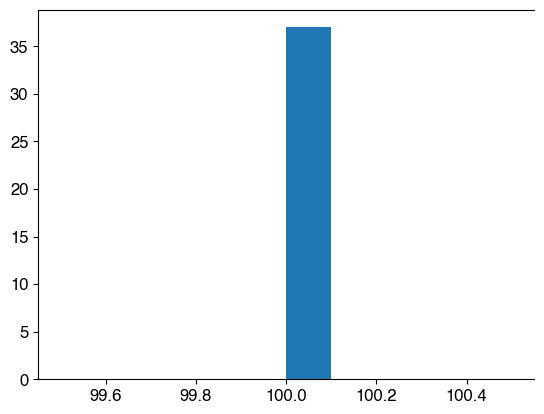

In [47]:
plt.hist(a)

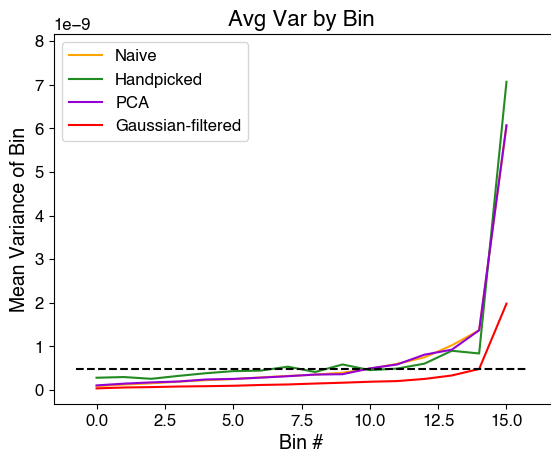

In [39]:
# weighted mu plots



def weighted_mu(weights, c, labels, title):
    # plots all four types of mean weights on top of each other
    fig, ax = plt.subplots()

    len_var = len(weights[-1])
    middle = len_var // 2

    kneedle = KneeLocator(range(len_var - middle), weights[-1][middle:], S=1, curve="convex")

    try:
        thresh_x = math.ceil(kneedle.knee)
    except: 
        thresh_x = len_std - middle - 1
        
    thresh = weights[-1][thresh_x + middle]
    
    for i in range(len(labels)):
        ax.plot(weights[i], color=c[i], label=labels[i])
    ax.set_title(title, fontsize=16)
    ax.plot(ax.get_xlim(), [thresh, thresh], 'k--')
    ax.set_xlabel('Bin #')
    ax.set_ylabel('Mean Variance of Bin')
    ax.set_ylim(ax.get_ylim()[0], ax.get_ylim()[1]*1.1)
    plt.legend()
    plt.savefig(title)
    plt.show()

colors = [color_n, color_4d, color_pca, 'red']
labels = ['Naive', 'Handpicked', 'PCA', 'Gaussian-filtered']
weighted_mu([var_naive_avg, std_4d_avg, std_pca_avg, var_naive_g1_avg], c = colors, labels=labels, title='Avg Var by Bin')
# weighted_mu([std_naive_l_avg, std_4d_l_avg, std_pca_l_avg, std_phate_l_avg], c=colors[:4], labels=labels[:4], title='Avg Long Window Var by Bin')
# weighted_mu([std_naive_s_avg, std_4d_s_avg, std_pca_s_avg, std_phate_s_avg], c=colors[:4], labels=labels[:4], title='Avg Short Window Var by Bin')



100%|██████████| 76/76 [00:01<00:00, 59.14it/s]


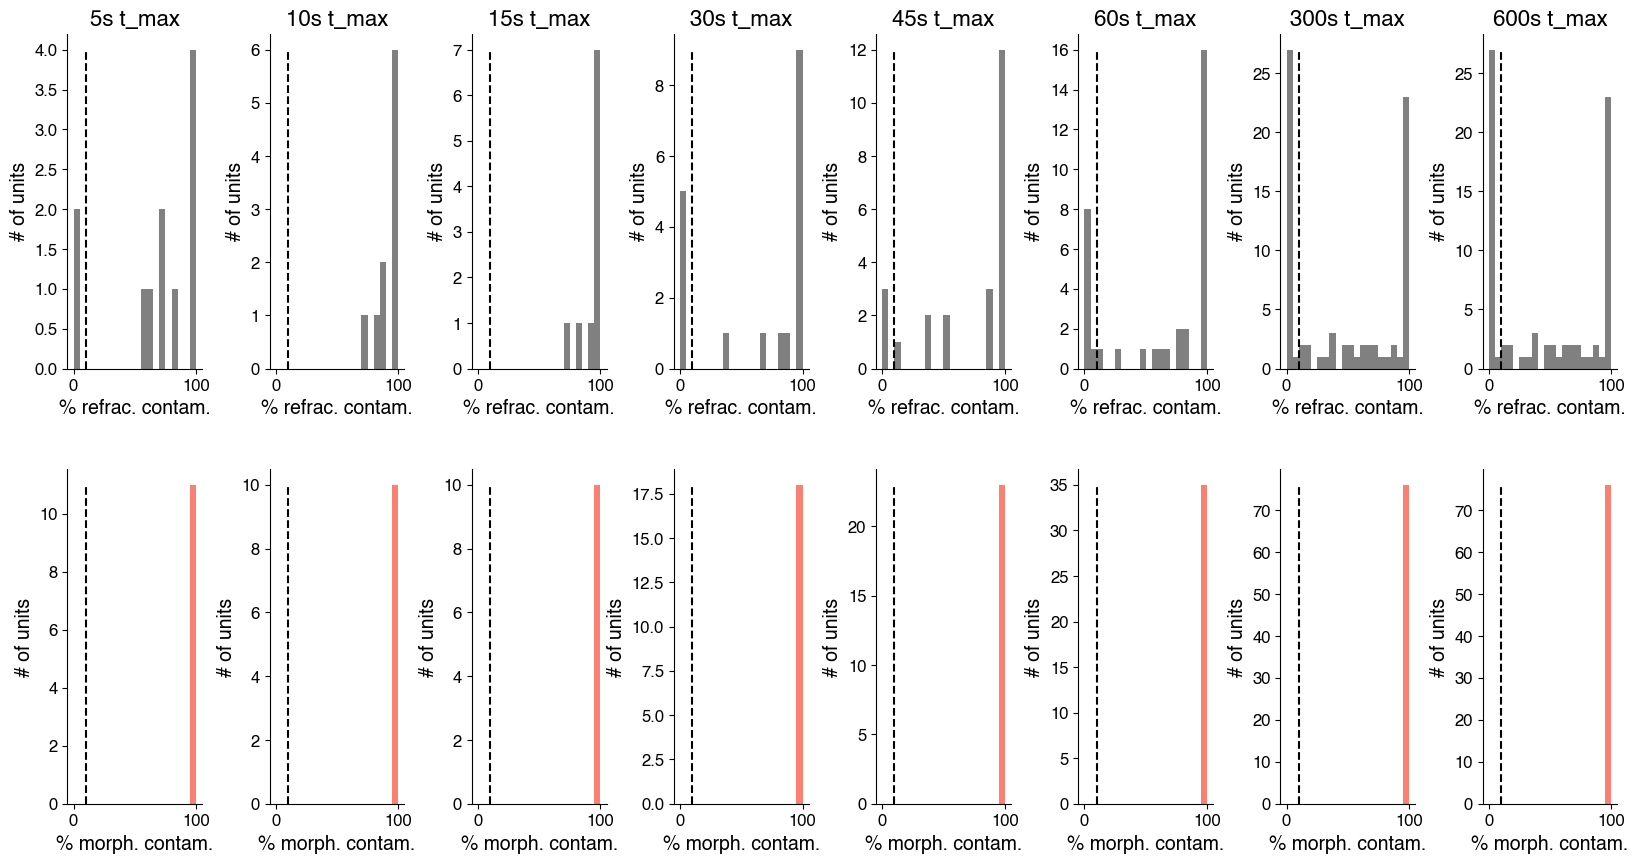

In [34]:
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
gray = .5 * np.ones(3)
sec_arr = [5, 10, 15, 30, 45, 60, 300, 600]

fig = plt.figure(figsize=(20,10), dpi=100)
grid = gridspec.GridSpec(2, 8, figure=fig, hspace=0.3, wspace=0.5)

contam_ref_units, contam_morph_units = [], []

for i in range(8):
    ops, camps, contam_pct, chan_map, templates, chan_best, amplitudes, st, clu, firing_rates, dshift = load_res(sec_arr[i])
    ax = fig.add_subplot(grid[i // 8, i % 8])
    nb=ax.hist(np.minimum(100, contam_pct), np.arange(0,105,5), color=gray)
    ax.plot([10, 10], [0, nb[0].max()], 'k--')
    ax.set_xlabel('% refrac. contam.')
    ax.set_ylabel('# of units')
    ax.set_title(f'{sec_arr[i]}s t_max', fontsize=16)

    ax = fig.add_subplot(grid[i // 8 + 1, i % 8])
    c_m =  contamination_morph()
    nb=ax.hist(np.minimum(100, c_m), np.arange(0,105,5), color='salmon')
    ax.plot([10, 10], [0, nb[0].max()], 'k--')
    ax.set_xlabel('% morph. contam.')
    ax.set_ylabel('# of units')

    # adding cont percents
    contam_ref_units.append((np.flatnonzero(contam_pct < 10).shape[0] / contam_pct.shape[0]))
    contam_morph_units.append((np.flatnonzero(np.array(c_m) < 10).shape[0] / len(c_m)))

plt.savefig('ks4_contamination_knee')

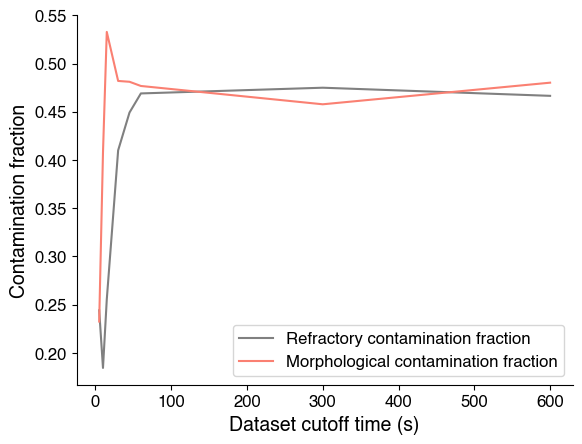

In [18]:
# figure showing fraction of cont. vs rec length
fig, ax = plt.subplots()

ax.plot(sec_arr, contam_ref_units, color=gray, label='Refractory contamination fraction')
ax.plot(sec_arr, contam_morph_units, color='salmon', label='Morphological contamination fraction')
ax.legend(loc='lower right')
ax.set_xlabel('Dataset cutoff time (s)')
ax.set_ylabel('Contamination fraction')
# r_value = pearsonr(contam_ref_units, contam_morph_units).statistic
# ax.annotate("r-squared = {:.3f}".format(r_value), (0.65, 0.3), xycoords='figure fraction')
plt.savefig('rec_len_fraction')
plt.show()